# Seattle Airbnb Project

# Business Understanding 

The datasets given are the following, calendar, listings and reviews. Just visually, the listing price seems to change drastically based on rental size, location and season. After each rental, customers leave reviews of their stay.

# Questions

The questions we will be looking to answer in this project are the following:

1)How do seasonal patterns affect rental rates and occupancy?

2)How do features correlate with rental rates?

3)How does mean occupancy rate over time change?

# Data Understanding

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython import display
%matplotlib inline
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
calendar = pd.read_csv('/Users/oscar/Desktop/Udacity/calendar.csv')
listing = pd.read_csv('/Users/oscar/Desktop/Udacity/listings.csv')
revenue = pd.read_csv('/Users/oscar/Desktop/Udacity/reviews.csv')

In [3]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [5]:
revenue.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


## Seasonal Factors

### Seasonal Price

In [6]:


#make float and replace $

calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True)
calendar['price'] = calendar['price'].astype(float)



In [7]:
price_med = calendar[['date', 'price']].groupby('date').median()
price_mean =calendar[['date', 'price']].groupby('date').mean()

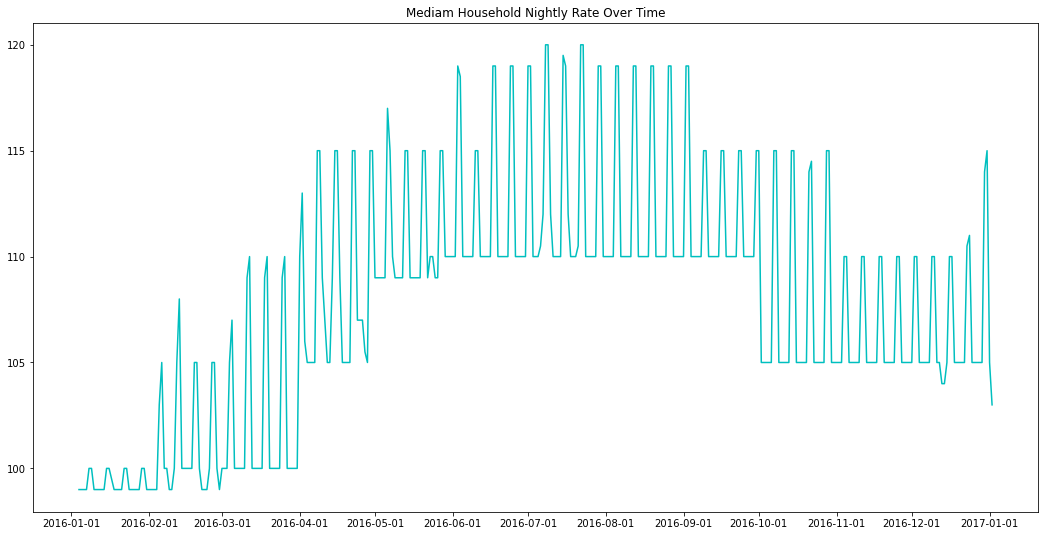

In [8]:
plt.figure(figsize=(18,9))
    
x = [datetime.strptime(date, '%Y-%m-%d') for date in price_med.index]
y = price_med['price']


# set x tick by month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

#plot
plt.title("Mediam Household Nightly Rate Over Time")
plt.plot(x, y, 'c-')
plt.show()

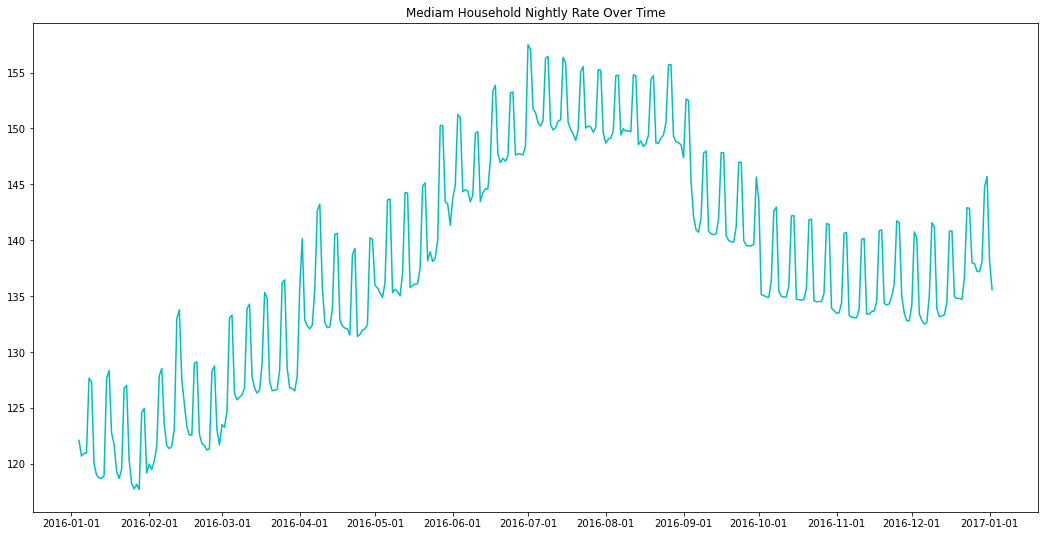

In [9]:
plt.figure(figsize=(18,9))
    
x = [datetime.strptime(date, '%Y-%m-%d') for date in price_mean.index]
y = price_mean['price']


# set x tick by month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

#plot
plt.title("Mediam Household Nightly Rate Over Time")
plt.plot(x, y, 'c-')
plt.show()

### Seasonal Occupied Ratio

In [10]:
#switch to string
calendar['available'] = calendar['available'].astype(str)
#create new column
calendar['binary'] = calendar['available']
#make binary variables
calendar['binary'] = calendar['binary'].replace("t", 0)
calendar['binary'] = calendar['binary'].replace("f", 1)
#Groupby Mean
occupancy = calendar[['date', 'binary']].groupby('date').mean()

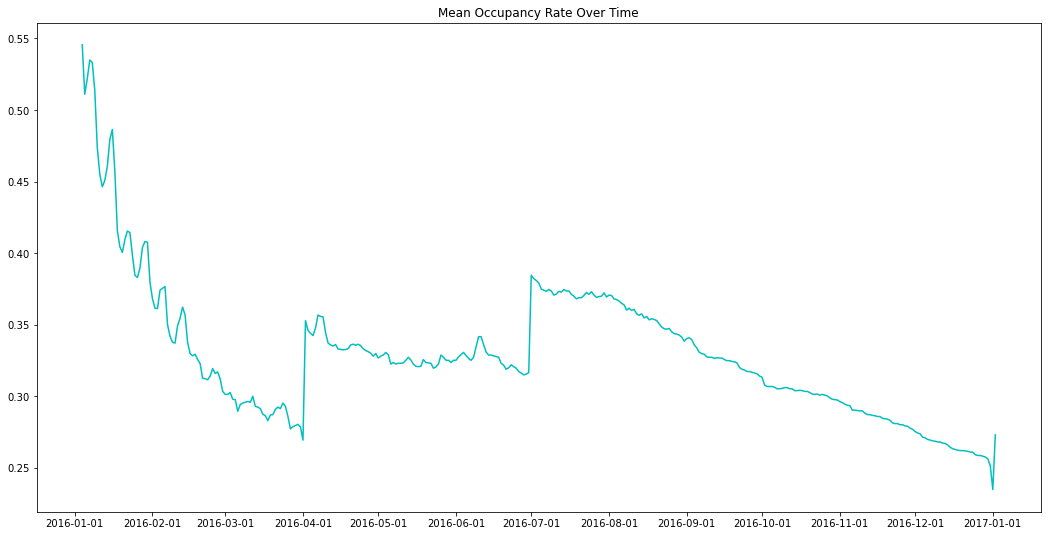

In [11]:
plt.figure(figsize=(18,9))
    
x = [datetime.strptime(date, '%Y-%m-%d') for date in occupancy.index]
y = occupancy['binary']

# set x tick by month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

#plot
plt.title("Mean Occupancy Rate Over Time")
plt.plot(x, y, 'c-')
plt.show()

# Correlation Features

In [12]:
print(listing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [17]:
list_clean = listing[["host_response_rate","host_is_superhost", "neighbourhood", "zipcode", "bathrooms", "bedrooms", "beds", "bed_type", "square_feet", "price", "guests_included", "number_of_reviews", "review_scores_rating", "cancellation_policy"]]

In [18]:
print(list_clean.isna().sum())
print("Length is " + str(len(list_clean)))

host_response_rate       523
host_is_superhost          2
neighbourhood            416
zipcode                    7
bathrooms                 16
bedrooms                   6
beds                       1
bed_type                   0
square_feet             3721
price                      0
guests_included            0
number_of_reviews          0
review_scores_rating     647
cancellation_policy        0
dtype: int64
Length is 3818


In [19]:
list_clean.drop(columns = ["square_feet"])
list_clean.info()
list_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_rate    3295 non-null   object 
 1   host_is_superhost     3816 non-null   object 
 2   neighbourhood         3402 non-null   object 
 3   zipcode               3811 non-null   object 
 4   bathrooms             3802 non-null   float64
 5   bedrooms              3812 non-null   float64
 6   beds                  3817 non-null   float64
 7   bed_type              3818 non-null   object 
 8   square_feet           97 non-null     float64
 9   price                 3818 non-null   object 
 10  guests_included       3818 non-null   int64  
 11  number_of_reviews     3818 non-null   int64  
 12  review_scores_rating  3171 non-null   float64
 13  cancellation_policy   3818 non-null   object 
dtypes: float64(5), int64(2), object(7)
memory usage: 417.7+ KB


,host_response_rate,host_is_superhost,neighbourhood,zipcode,bathrooms,bedrooms,beds,bed_type,square_feet,price,guests_included,number_of_reviews,review_scores_rating,cancellation_policy
0,96%,f,Queen Anne,98119,1.0,1.0,1.0,Real Bed,NaN,$85.00,2,207,95.0,moderate
1,98%,t,Queen Anne,98119,1.0,1.0,1.0,Real Bed,NaN,$150.00,1,43,96.0,strict
2,67%,f,Queen Anne,98119,4.5,5.0,7.0,Real Bed,NaN,$975.00,10,20,97.0,strict
3,NaN,f,Queen Anne,98119,1.0,0.0,2.0,Real Bed,NaN,$100.00,1,0,NaN,flexible
4,100%,f,Queen Anne,98119,2.0,3.0,3.0,Real Bed,NaN,$450.00,6,38,92.0,strict


In [20]:
#list_clean['price'] = list_clean['price'].map(lambda price: float(price[1:].replace(',', '')), na_action='ignore')
list_clean['price'] = list_clean.price.astype(str)
list_clean['price'] = list_clean['price'].str.replace(',', '')
list_clean['price'] = list_clean['price'].str.replace('$', '')
list_clean['price'] = list_clean.price.astype(float)

list_clean['host_response_rate'] = list_clean.host_response_rate.astype(str)
list_clean['host_response_rate'] = list_clean.host_response_rate.str.replace("%","")
list_clean['host_response_rate'] = list_clean.host_response_rate.astype(float)

print(list_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_rate    3295 non-null   float64
 1   host_is_superhost     3816 non-null   object 
 2   neighbourhood         3402 non-null   object 
 3   zipcode               3811 non-null   object 
 4   bathrooms             3802 non-null   float64
 5   bedrooms              3812 non-null   float64
 6   beds                  3817 non-null   float64
 7   bed_type              3818 non-null   object 
 8   square_feet           97 non-null     float64
 9   price                 3818 non-null   float64
 10  guests_included       3818 non-null   int64  
 11  number_of_reviews     3818 non-null   int64  
 12  review_scores_rating  3171 non-null   float64
 13  cancellation_policy   3818 non-null   object 
dtypes: float64(7), int64(2), object(5)
memory usage: 417.7+ KB
None


<ipython-input-20-0f98f415b8fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_clean['price'] = list_clean.price.astype(str)
<ipython-input-20-0f98f415b8fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_clean['price'] = list_clean['price'].str.replace(',', '')
<ipython-input-20-0f98f415b8fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

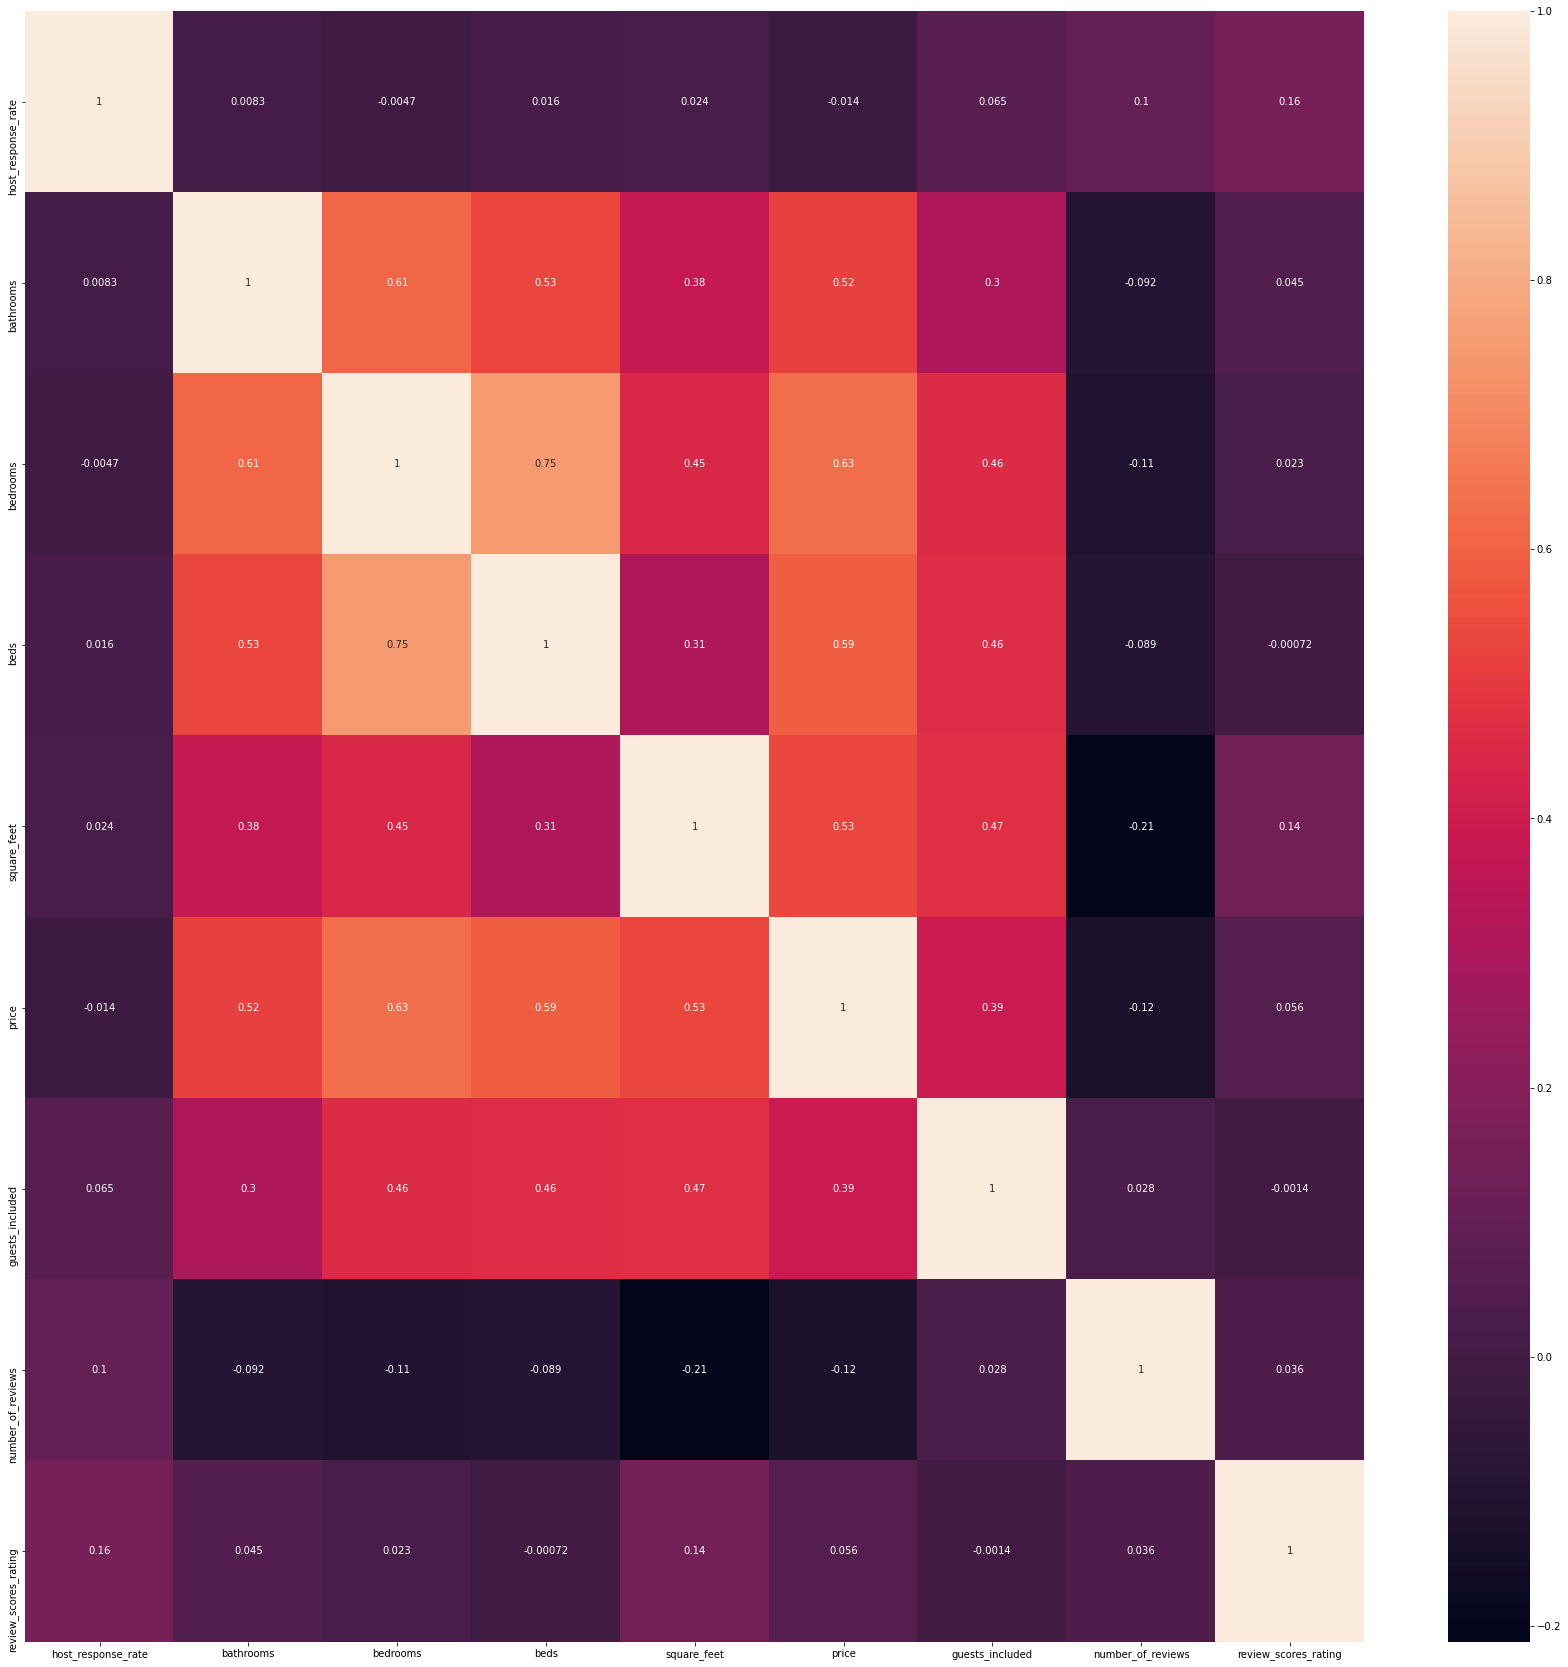

In [21]:
plt.figure(figsize=(30,30))

sns.heatmap(list_clean.corr(), annot = True)

plt.show()